# Estimating Clients' Needs  

Here we have a random extraction of a dataset made up of a wealth manager's customers. The data is anonymous, mostly clean and NOT always normalized/scaled.
We intend to estimate some investments needs for these customers using Data Science techniques.  

Estimating needs is useful for many reasons, for example:  
- as a basis for a Recommender System, i.e. finding the "Next Best Action" - basically needs can be the key inputs of content-based/knowledge-based filtering algorithms - this is our key task here;  
- product targeting/governance (also from the compliance point of view) as MIFID/IDD standards require a matching between customer needs and needs satisfied by the product - but is basically an institutional view of a recommendation system.  

The dataset is called "Needs" and is conveniently saved as a .mat file, even if you have also the corresponding .xls file.  

In the dataset we have a table **Needs**, with some (maybe) relevant features and two responses:  
- AccumulationInvest, which is about **Accumulation investing**, typically using dollar-cost averaging (you invest small amounts of your money at certain intervals over the course of time); the response is boolean: 1 = high propensity | 0 = low propensity;  
- AccomeInvest, which is about **Income investing**, typically through lump sum investing (one shot); the response is boolean: 1 = high propensity | 0 = low propensity.  

Then we have a second table, **Products**, with some products (funds, segregated accounts, unit-linked), their **type** (1 = Accumulation, 0 = Income), and their **risk level** (normalized in the range [0,1], usually; this is the synthetic risk and reward indicator or SRRI, for the product).  
The recommendation system is based on two key steps  
- We want to learn to recognize customers with above-average propensity to invest (AccumulationInvest = 1, and/or IncomeInvest = 1);
- For each customer we will associate a product with each need, finding the best match, based on the product type/need and its risk level, and that will be the personalized product recommendation, ie, the Next Best Action for that specific client.

## Data exploration

Let start by visualizing the data

In [1]:
#Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt


In [2]:
dataset = pd.read_excel('Needs.xls', index_col=0)
dataset.head()

,Age,Gender,FamilyMembers,FinancialEducation,RiskPropensity,Income,Wealth,IncomeInvestment,AccumulationInvestment
ID,,,,,,,,,
1,60,0,2,0.228685,0.233355,68.181525,53.260067,0,1
2,78,0,2,0.358916,0.170911,21.807595,135.550048,1,0
3,33,1,2,0.317515,0.249703,23.252747,66.303678,0,1
4,69,1,4,0.767685,0.654597,166.189034,404.997689,1,1
5,58,0,3,0.429719,0.349039,21.186723,58.911930,0,0


Here, we can see a subset of our dataset witch has 9 features including 3 qualitatives features ('Gender', 'IncomeInvestment' and 'AccumulationInvestment').  
  
**Remarque:** I modified the column name 'Income ' to 'Income' !

In [3]:
#Let plot the data
#sns.pairplot(dataset[["Age", "Gender", "FinancialEducation", "RiskPropensity", "Income","Wealth"]], hue='Gender', data=dataset)

We can see some intersting information thanks to this plot :
- A high correlation between RiskPropensity and FinancialEducation
- We have some outliers data (in wealth and Income) 

In [4]:
from scipy.stats import pearsonr
matCorr = dataset.corr('pearson')
corr = round(matCorr['RiskPropensity'].values[3] * 100, 2)
print("The pearson correlation between the two factors is", corr, " %")


The pearson correlation between the two factors is 68.33  %


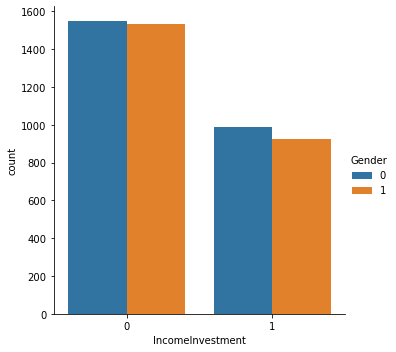

In [5]:
sns.catplot(data=dataset, x="IncomeInvestment", kind="count", hue="Gender")

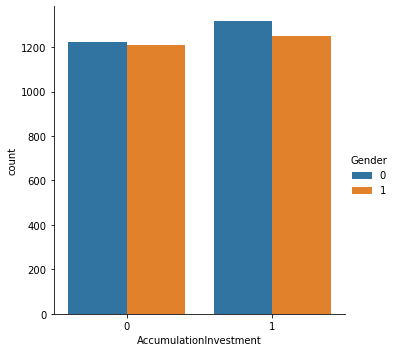

In [6]:
sns.catplot(data=dataset, x="AccumulationInvestment", kind="count", hue="Gender")

## Preprocessing
The stpes are:
- Scales features
- Treate Outliers
- Treatment of correlate features
- Dataset splitting

In [7]:
from scipy.stats import zscore
from sklearn.utils import shuffle

#Log transformation
logIncome = np.log(dataset[["Income"]].values)
logWealth = np.log(dataset[["Wealth"]].values)

X = dataset[["Age", "FamilyMembers", "FinancialEducation", "RiskPropensity"]].values
X =  zscore(np.concatenate((X, logIncome, logWealth), axis=1))
X = np.append(X, dataset[['Gender']].values, axis=1) #We add the gender column
t_inc = dataset['IncomeInvestment'].values == 1
t_acc = dataset['AccumulationInvestment'].values == 1

In [8]:
#Create the subsets
from sklearn.model_selection import train_test_split

#Train = 72 % ; Test = 10 % ; Validation = 18 %
#X_train, X_test, Inc_train, Inc_test, Acc_train, Acc_test = train_test_split(X, t_inc, t_acc, test_size=0.1, shuffle=True, random_state=0) #Test and Train sets
X_train, X_val, Inc_train, Inc_val, Acc_train, Acc_val = train_test_split(X, t_inc, t_acc, test_size=0.2, shuffle=True, random_state=5) #Validation set


/usr/local/lib/python3.8/dist-packages/seaborn/axisgrid.py:2182: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


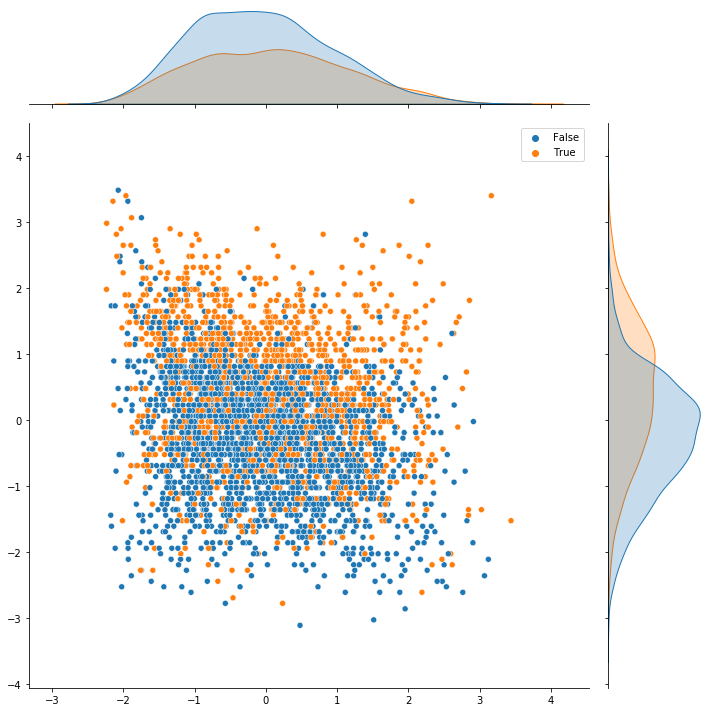

In [9]:
plot = sns.jointplot(data=X_train, x=X_train[:,3], y=X_train[:,0], hue=Inc_train, size=10)

## Models

In this part, we will try to code all the model we saw during the lectures. Then, we will see there performance on the Train and Validation sets.  
We will implement:
- Logistic Regression model
- Perceptron model
- Random Forest model
- Neural Networks model
- K-NN model

In [10]:
#Models libraries
from sklearn.linear_model import LogisticRegressionCV, Perceptron
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier as KNN
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense

2022-04-17 17:52:26.030099: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-17 17:52:26.030143: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [11]:
#Logistic Models
logIncMod, logAccMod = LogisticRegressionCV(), LogisticRegressionCV()
logIncMod.fit(X_train, Inc_train)
logAccMod.fit(X_train,Acc_train)
lassoIncModel, lassoAccModel = LogisticRegressionCV(penalty='l1', solver='saga'), LogisticRegressionCV(penalty='l1', solver='saga')
ridgeIncModel, ridgeAccModel = LogisticRegressionCV(penalty="l2"), LogisticRegressionCV(penalty="l2")
lassoIncModel.fit(X_train, Inc_train); lassoAccModel.fit(X_train, Acc_train)
ridgeIncModel.fit(X_train, Inc_train); ridgeAccModel.fit(X_train, Acc_train)

LogisticRegressionCV()

In [12]:
#Perceptron Model
prcptIncMod, prcptAccMod = Perceptron(), Perceptron()
prcptIncMod.fit(X_train, Inc_train)
prcptAccMod.fit(X_train, Acc_train)

Perceptron()

In [13]:
#Random Forest
rfModInc, rfModAcc = RandomForestClassifier(), RandomForestClassifier()
rfModInc.fit(X_train, Inc_train)
rfModAcc.fit(X_train, Acc_train)

RandomForestClassifier()

In [14]:
#Neural Networks
dim, batch = len(X[0]), len(X_train)//100
nnIncMod, nnAccMod = Sequential(), Sequential()
nnIncMod.add(Dense(units=14, activation='sigmoid', input_dim=dim))
nnIncMod.add(Dense(units=14, activation='sigmoid'))
nnIncMod.add(Dense(units=1, activation='sigmoid'))#output layer
nnIncMod.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
nnIncMod.fit(X_train, Inc_train, batch_size=batch, epochs=3000, verbose=0)

nnAccMod.add(Dense(units=14, activation='sigmoid', input_dim=dim))
nnAccMod.add(Dense(units=14, activation='sigmoid'))
nnAccMod.add(Dense(units=1, activation='sigmoid'))#output layer
nnAccMod.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
nnAccMod.fit(X_train, Acc_train, batch_size=batch, epochs=3000, verbose=0)

2022-04-17 17:52:30.805348: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-17 17:52:30.805393: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-17 17:52:30.805417: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (emmalito-KLVL-WXX9): /proc/driver/nvidia/version does not exist
2022-04-17 17:52:30.806585: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
#KNN
k = 3
knnIncMod, knnAccMod = KNN(n_neighbors=k, metric='euclidean'), KNN(n_neighbors=k, metric='euclidean')
knnIncMod.fit(X_train, Inc_train)
knnAccMod.fit(X_train, Acc_train)

KNeighborsClassifier(metric='euclidean', n_neighbors=3)

### Remark
For the logistic regression, we can also use other function for the Lasso and Ridge model (ex: RidgeClassifierCV,...) but we choose to not do it.

### Result of the model

Lets see how the model perform the validation set. 

In [16]:
from sklearn.metrics import confusion_matrix

# IncomeInvesstisment prediction
predInc = logIncMod.predict(X_val)
predLassoInc = lassoIncModel.predict(X_val)
predRidgeInc = ridgeIncModel.predict(X_val)
predPerceptronInc = prcptIncMod.predict(X_val)
predRFInc = rfModInc.predict(X_val)
predNnInc = nnIncMod.predict(X_val)
predKnnInc = knnIncMod.predict(X_val)

# AccumuulentInvt prediction
predAcc = logAccMod.predict(X_val)
predLassoAcc = lassoAccModel.predict(X_val)
predRidgeAcc = ridgeAccModel.predict(X_val)
predPerceptronAcc = prcptAccMod.predict(X_val)
predRFAcc = rfModAcc.predict(X_val)
predNnAcc = nnAccMod.predict(X_val)
predKnnAcc = knnAccMod.predict(X_val)

In [17]:
def valueModel(model, isInc=1):
    if isInc:
        print("Accuracy mean for train : ", model.score(X_val, Inc_val), " Accuracy mean for validation = ", model.score(X_train, Inc_train))
    else:
        print("Accuracy : ", model.score(X_val, Acc_val), " Score = ", model.score(X_train, Acc_train))

def confusionMat(prediction, isInc=1, plot=False):
    if isInc:
        cm = confusion_matrix(Inc_val, prediction)
    else:
        cm = confusion_matrix(Acc_val, prediction)
    if not plot: print(cm)
    if plot:
        group_names = ["True Neg","False Pos","False Neg","True Pos"]
        group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
        group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
        labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
        labels = np.asarray(labels).reshape(2,2)
        sns.heatmap(cm, annot=labels, fmt="", cmap='Blues')
    TN = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0] 
    TP = cm[1][1]
    TPR = TP/(TP+FN) ; P = TP/(TP+FP) 
    TNR = (TN/(TN+FP)) ; F1 = (2*P*TPR)/(P+TPR)
    acc = (TP+TN)/(TP+TN+FP+FN)
    print("Measures:")
    print(f'Sensitivity = {TPR:2.2%} ;  Specificity = {TNR:2.2%} ; Precision = {P:2.2%} ; F1 score = {F1:2.2%} ; Accuracy = {acc:2.2%}')
    print()

In [18]:
#Logistic model
print("Lasso model for Inc : ")
confusionMat(predLassoInc)

print("Lasso model for Acc : ")
confusionMat(predLassoAcc, 0)

Lasso model for Inc : 
[[569  89]
 [136 206]]
Measures:
Sensitivity = 60.23% ;  Specificity = 86.47% ; Precision = 69.83% ; F1 score = 64.68% ; Accuracy = 77.50%

Lasso model for Acc : 
[[274 217]
 [135 374]]
Measures:
Sensitivity = 73.48% ;  Specificity = 55.80% ; Precision = 63.28% ; F1 score = 68.00% ; Accuracy = 64.80%



For the logistic models, the result is not bad especially for the IncomeInvestment model. We can calibrate the parameters for see if we can significatvly improve the models.

In [19]:
#Perceptron
print("Perceptron model for Inc : ")
confusionMat(predPerceptronInc)

print("Perceptron model for Acc : ")
confusionMat(predPerceptronAcc, 0)

Perceptron model for Inc : 
[[488 170]
 [179 163]]
Measures:
Sensitivity = 47.66% ;  Specificity = 74.16% ; Precision = 48.95% ; F1 score = 48.30% ; Accuracy = 65.10%

Perceptron model for Acc : 
[[204 287]
 [158 351]]
Measures:
Sensitivity = 68.96% ;  Specificity = 41.55% ; Precision = 55.02% ; F1 score = 61.20% ; Accuracy = 55.50%



The results are very bad for the perceptron as expected. We forgot this model.

RF model for Inc : 
Measures:
Sensitivity = 64.62% ;  Specificity = 92.10% ; Precision = 80.95% ; F1 score = 71.87% ; Accuracy = 82.70%



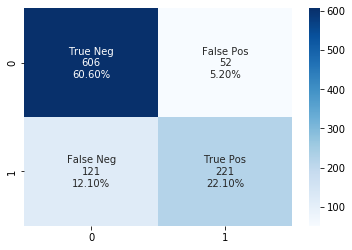

In [20]:
#Random Forest model
print("RF model for Inc : ")
confusionMat(predRFInc, plot=True)

RF model for Acc : 
Measures:
Sensitivity = 75.44% ;  Specificity = 83.30% ; Precision = 82.40% ; F1 score = 78.77% ; Accuracy = 79.30%



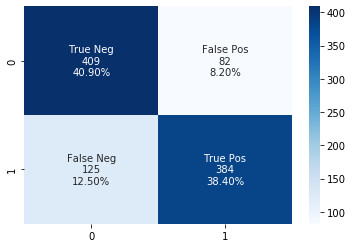

In [21]:
print("RF model for Acc : ")
confusionMat(predRFAcc, 0, True)

The results of the models are very good. The precision and accuracy are very hight. We can try to improve the models via the hyperparameters.

NN model for Inc
Measures:
Sensitivity = 60.23% ;  Specificity = 90.27% ; Precision = 76.30% ; F1 score = 67.32% ; Accuracy = 80.00%



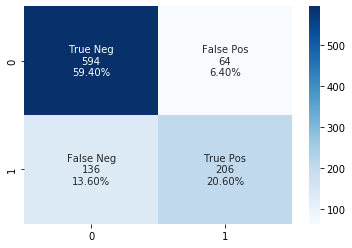

In [22]:
#Neural Networks model
ipre = (predNnInc > 0.5).astype(int)
print("NN model for Inc")
confusionMat(ipre, plot=True)

NN model for Acc
Measures:
Sensitivity = 74.26% ;  Specificity = 86.15% ; Precision = 84.75% ; F1 score = 79.16% ; Accuracy = 80.10%



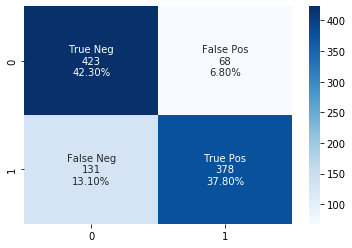

In [23]:
apre = (predNnAcc > 0.5).astype(int)
print("NN model for Acc")
confusionMat(apre, isInc=0, plot=True)

Neural Networks model is fine for the IncomeInvestment model but for the AccumulationInvestment, is bad. We didn't exepct that so we can try to improve it. 

In [24]:
#K-Nearest Neigthbhor
print("KNN model for Inc")
confusionMat(predKnnInc)
print(nnIncMod.evaluate(X_val, Inc_val))

print("KNN model for Acc")
confusionMat(predKnnAcc, 0)
print(nnAccMod.evaluate(X_val, Acc_val))

KNN model for Inc
[[526 132]
 [152 190]]
Measures:
Sensitivity = 55.56% ;  Specificity = 79.94% ; Precision = 59.01% ; F1 score = 57.23% ; Accuracy = 71.60%

32/32 [==============================] - 0s 2ms/step - loss: 0.5438 - accuracy: 0.8000
[0.5437507033348083, 0.800000011920929]
KNN model for Acc
[[318 173]
 [169 340]]
Measures:
Sensitivity = 66.80% ;  Specificity = 64.77% ; Precision = 66.28% ; F1 score = 66.54% ; Accuracy = 65.80%

32/32 [==============================] - 0s 2ms/step - loss: 0.4959 - accuracy: 0.8010
[0.49594631791114807, 0.8009999990463257]


For the end, the KNN model is not bad, we can compare it to the logistic models. But we choose to not continue with this model because we think this algo is not pertinent for our prediction.

## Hyperparametre calibration  
  
Now, we will try to improve the quality of the model by calibrate the hyperparameters.

### Random Forest
  
We will try a set of input for the function and choose the better one thanks to the a function of the sklearn lybrary.

In [25]:
from sklearn.model_selection import RandomizedSearchCV

#Random Forest
paramGrid = {'bootstrap': [True, False],
            'criterion': ['gini', 'entropy'],
            'max_depth': [None, 5, 10, 30, 50, 70],
            'max_features': ['sqrt','auto', 'log2'],
            'n_estimators': [50, 100, 300],
            #'n_features': [4,5,6,7],
            'warm_start': [False, True]}
rf_randomInc = RandomizedSearchCV(estimator = RandomForestClassifier(n_jobs=-1), n_iter=50, param_distributions = paramGrid, n_jobs = -1, verbose=0)
rf_randomInc.fit(X_train, Inc_train)
rf_randomAcc = RandomizedSearchCV(estimator = RandomForestClassifier(n_jobs=-1), n_iter=50, param_distributions = paramGrid, n_jobs = -1, verbose=0)
rf_randomAcc.fit(X_train, Acc_train)
rfIncMod = rf_randomInc.best_estimator_
rfAccMod = rf_randomAcc.best_estimator_

In [26]:
print(rfIncMod.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 70, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 300, 'n_jobs': -1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [27]:
print(rfModInc.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


Measures:
Sensitivity = 63.45% ;  Specificity = 91.49% ; Precision = 79.49% ; F1 score = 70.57% ; Accuracy = 81.90%



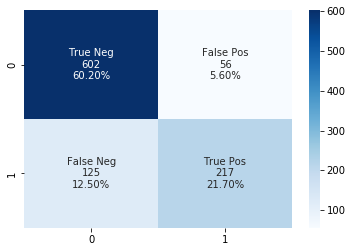

In [28]:
iii = rfIncMod.predict(X_val)
confusionMat(iii, plot=True)

Measures:
Sensitivity = 64.62% ;  Specificity = 92.10% ; Precision = 80.95% ; F1 score = 71.87% ; Accuracy = 82.70%



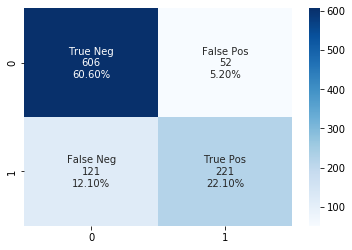

In [29]:
confusionMat(predRFInc, plot=True)

In [30]:
eee = rfAccMod.predict(X_val)
confusionMat(eee, 0)
confusionMat(predRFAcc, 0)

[[410  81]
 [122 387]]
Measures:
Sensitivity = 76.03% ;  Specificity = 83.50% ; Precision = 82.69% ; F1 score = 79.22% ; Accuracy = 79.70%

[[409  82]
 [125 384]]
Measures:
Sensitivity = 75.44% ;  Specificity = 83.30% ; Precision = 82.40% ; F1 score = 78.77% ; Accuracy = 79.30%



In [31]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

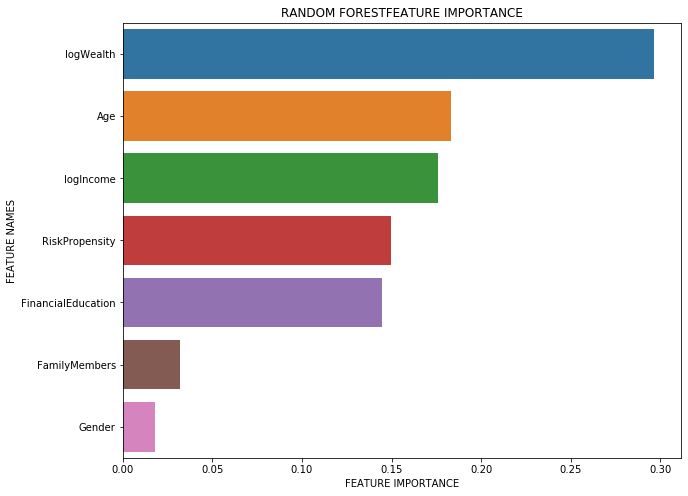

In [32]:
c = ["Age", "FamilyMembers", "FinancialEducation", "RiskPropensity", "logIncome", "logWealth", "Gender"]
plot_feature_importance(rfIncMod.feature_importances_, c,'RANDOM FOREST')

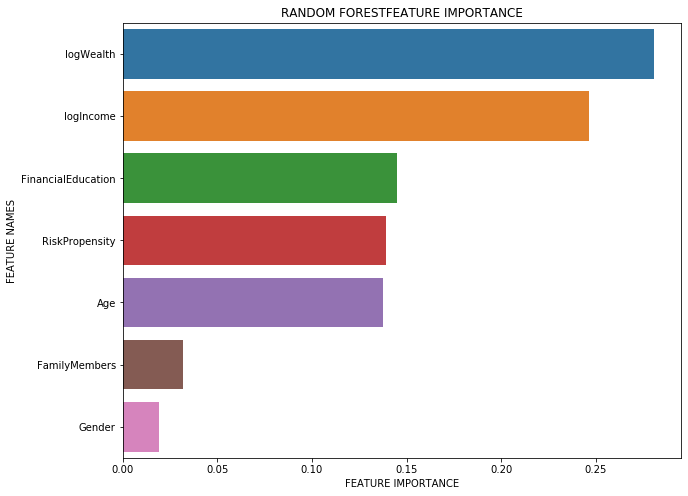

In [33]:
c = ["Age", "FamilyMembers", "FinancialEducation", "RiskPropensity", "logIncome", "logWealth", "Gender"]
plot_feature_importance(rfAccMod.feature_importances_, c,'RANDOM FOREST')

In [34]:
"""from sklearn.model_selection import GridSearchCV

#Logistic model
paramGrid = {'C': [0.01, 0.2, 0.5, 1.0, 2.5],
            'class_weight': [None, 'balanced'],
            'fit_intercept': [False,True],
            'penalty': ['l1', 'l2', 'elasticnet'],
            'random_state': [None, 5, 10, 20],
            'warm_start': [False,True]}
randomIncLogMod = GridSearchCV(estimator=LogisticRegressionCV(solver='saga', n_jobs=-1), cv=10, param_grid=paramGrid, n_jobs=-1)
randomIncLogMod.fit(X_train, Inc_train)
incMod = randomIncLogMod.best_estimator_
randomAccLogMod = GridSearchCV(estimator=LogisticRegressionCV(solver='saga', n_jobs=-1), param_grid=paramGrid, n_jobs=-1)
randomAccLogMod.fit(X_train, Acc_train)
accMod = randomAccLogMod.best_estimator_"""

"from sklearn.model_selection import GridSearchCV\n\n#Logistic model\nparamGrid = {'C': [0.01, 0.2, 0.5, 1.0, 2.5],\n            'class_weight': [None, 'balanced'],\n            'fit_intercept': [False,True],\n            'penalty': ['l1', 'l2', 'elasticnet'],\n            'random_state': [None, 5, 10, 20],\n            'warm_start': [False,True]}\nrandomIncLogMod = GridSearchCV(estimator=LogisticRegressionCV(solver='saga', n_jobs=-1), cv=10, param_grid=paramGrid, n_jobs=-1)\nrandomIncLogMod.fit(X_train, Inc_train)\nincMod = randomIncLogMod.best_estimator_\nrandomAccLogMod = GridSearchCV(estimator=LogisticRegressionCV(solver='saga', n_jobs=-1), param_grid=paramGrid, n_jobs=-1)\nrandomAccLogMod.fit(X_train, Acc_train)\naccMod = randomAccLogMod.best_estimator_"

# Questions

- Pourquoi shuffle notre dataset et sommes nous obligés (si oui, quand) ?
- Sommes nous obligés de normaliser nos data pour une régression ?
- Si oui, pourquoi et comment ça affectera notre modèle ?
- Est-ce que le perceptron marche sur plus que 2 features ?

# Remarques


- La normalisation ne modifie pas la prédiction des data
- Lasso et Rigde inutile (peut être parce que notre modèle n'est pas complex)

# Prediction

Using Random Forest our best ensemble classifier, we get:
1 predicted labels

In [35]:
#productData = pd.read_excel('Needs.xls', index_col=0)
xls = pd.ExcelFile('Needs.xls')
productsData = pd.read_excel(xls, 'Products', index_col=0)
productsData.head()

,Type,Risk
IDProduct,,
1,1,0.55
2,0,0.30
3,0,0.12
4,0,0.44
5,1,0.41


In [36]:
Product_inc = productsData[productsData["Type"]==1].sort_values(by=['Risk'], ascending=False)
Product_acc = productsData[productsData["Type"]==0].sort_values(by=['Risk'], ascending=False)
print(Product_acc)

           Type  Risk
IDProduct            
4             0  0.44
2             0  0.30
10            0  0.13
3             0  0.12


In [37]:
print(Product_acc.index[1])

2


In [38]:
def NBA_acc(clientRisk):
    index=0
    while index < len(Product_acc) and clientRisk < Product_acc["Risk"].values[index]:
        index+=1
    if index == len(Product_acc):
        return 0
    return Product_acc.index.values[index:] 

In [39]:
def NBA_inc(clientRisk):
    index=0
    while index < len(Product_inc) and clientRisk < Product_inc["Risk"].values[index]:
        index+=1
    if index == len(Product_inc):
        return 0
    return Product_inc.index.values[index:] 

In [40]:
print(dataset['RiskPropensity'].values)

[0.23335464 0.17091141 0.24970305 ... 0.40277092 0.43141901 0.35316721]


In [41]:
idClient = dataset.index.values
riskClient = dataset['RiskPropensity'].values
NBA=[[0,0,0]]*len(X)
for index in range(len(X)) :
    clientRisk = riskClient[index]
    NBA[index] = idClient[index], NBA_inc(clientRisk), NBA_acc(clientRisk)


In [42]:
for i in range(4):
    print("IdClient:", NBA[i][0], " needs Inc product(s):", NBA[i][1], "and Acc product(s):", NBA[i][2])

IdClient: 1  needs Inc product(s): 0 and Acc product(s): [10  3]
IdClient: 2  needs Inc product(s): 0 and Acc product(s): [10  3]
IdClient: 3  needs Inc product(s): 0 and Acc product(s): [10  3]
IdClient: 4  needs Inc product(s): [1 8 5 6 9] and Acc product(s): [ 4  2 10  3]


In [43]:
#b = len(X_train)//100
#lr_model_history = nnAccMod.fit(X_train, Acc_train, batch_size=b, epochs=300, validation_data=(X_val, Acc_val), verbose=0)
#
## Plot the loss function
#fig, ax = plt.subplots(1, 1, figsize=(10,6))
#ax.plot(np.sqrt(lr_model_history.history['loss']), 'r', label='train')
#ax.plot(np.sqrt(lr_model_history.history['val_loss']), 'b' ,label='val')
#ax.set_xlabel(r'Epoch', fontsize=20)
#ax.set_ylabel(r'Loss', fontsize=20)
#ax.legend()
#ax.tick_params(labelsize=20)
#
## Plot the accuracy
#fig, ax = plt.subplots(1, 1, figsize=(10,6))
#ax.plot(np.sqrt(lr_model_history.history['accuracy']), 'r', label='train')
#ax.plot(np.sqrt(lr_model_history.history['val_accuracy']), 'b' ,label='val')
#ax.set_xlabel(r'Epoch', fontsize=20)
#ax.set_ylabel(r'Accuracy', fontsize=20)
#ax.legend()
#ax.tick_params(labelsize=20)